# EDA

In [36]:
!pip install python-gdcm
!pip install plotly==5.3.1 

     |████████████████████████████████| 23.9 MB 1.6 MB/s eta 0:00:01     |███████████████████████████     | 20.2 MB 1.1 MB/s eta 0:00:04
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [62]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
from skimage import exposure
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_white"
%matplotlib inline

# pydicom
#import pydicom
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#from pydicom import dcmread, read_file
#from pydicom.data import get_data_file
#from fastai.imports import *
#from fastai.medical.imaging import *

#import cv2

# color
from colorama import Fore, Back, Style

import seaborn as sns
#sns.set(style="whitegrid")

# plotly
#import plotly.express as px
#import plotly

# Suppress warnings 
#import warnings
#warnings.filterwarnings('ignore')

from ast import literal_eval


y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
res = Style.RESET_ALL



# Settings for pretty nice plots
#plt.style.use('fivethirtyeight')
#plt.show()

Dado a que se están utilizando imágenes DICOM se deben instalar la librería correspondiente para su manejo

## Exploración de datos

Cargamos los datos en memoria

In [55]:
PATH = ''
#submission = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv', index_col=None)
image_df = pd.read_csv('train_image_level.csv', index_col=None)
study_df = pd.read_csv('train_study_level.csv', index_col=None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
print(f"{y_}Train image level csv shape : {image_df.shape}{res}\n{g_}Train study level csv shape : {study_df.shape}{res}")

Train image level csv shape : (6334, 4)
Train study level csv shape : (6054, 5)


In [14]:
all_files = []
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [24]:
set_all_files = set(all_files)
contains_duplicates = len(set_all_files) != len(all_files)
print(f"{b_} Contains duplicates: {contains_duplicates}")

 Contains duplicates: False


In [53]:
all_files

['train/f254d359e0ef/25aa6ddac5c0/84ebe17672e4.dcm',
 'train/0f37cd26d3a9/00607318e904/5022177a3ac8.dcm',
 'train/a03daefd7f50/46e2f92d9142/ef1a73df3463.dcm',
 'train/6fc05a848fc4/c322e2dc560a/ceff5e389de0.dcm',
 'train/7775226c7ce8/bc796fb417a9/a4cf0a951d9b.dcm',
 'train/285d0448622f/15ba0101c8f9/d908edf349ed.dcm',
 'train/724d6bc409ed/8d7036d22f06/307a239c069d.dcm',
 'train/ea3aaa187640/56b35e42f5af/a226584b9b79.dcm',
 'train/59a91c5701e6/b63b2808e34a/01e66c5fc9f3.dcm',
 'train/de7934b835ca/8938f04190e7/691e08460a87.dcm',
 'train/5a869900cfef/c56bc984ac1b/300b663f5b0e.dcm',
 'train/aee6f16805c5/95e787961bc4/66576b208730.dcm',
 'train/490545ad8409/12391b4052e0/5807a187f396.dcm',
 'train/bae29add20cf/6ceb0617712c/b452962df0ba.dcm',
 'train/39d2e8b3e170/ad4947e2f89f/63d91d1f0079.dcm',
 'train/33f2cae828db/112306c9cdc1/ed9855c3cf17.dcm',
 'train/7ea118331dfe/51e2f2abfde4/81965b5cb107.dcm',
 'train/7bb06ca2150c/e0824ae53d47/9bd0005d2873.dcm',
 'train/6de88cb78697/082fdb8a6318/e545e07a7a06

Con los datos listos, procedemos a analizar lo que el conjunto de datos de estudio y de imágenes nos brindan

**Study level csv**

In [11]:
study_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [22]:
study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


**Image Level csv**

In [25]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


In [26]:
image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


Se procede a manejar las diferentes categorias con diferentes colores

In [27]:
study_grp = pd.melt(study_df, id_vars=list(study_df.columns)[:1], value_vars=list(study_df.columns)[1:],
             var_name='label', value_name='value')
study_grp = study_grp.loc[study_grp['value']!=0]
colors = {'Typical Appearance' : '#DCD427',
'Negative for Pneumonia' : '#0092CC',
'Indeterminate Appearance' : '#CC3333',
#'Atypical Appearance' : '#779933',
          'Atypical Appearance' : '#E6E6E6'
         }

study_grp = study_grp.groupby('label').sum().sort_values('value',ascending=False).reset_index()
study_grp['color'] = study_grp['label'].apply(lambda x: colors[x])
study_grp

,label,value,color
0,Typical Appearance,2855,#DCD427
1,Negative for Pneumonia,1676,#0092CC
2,Indeterminate Appearance,1049,#CC3333
3,Atypical Appearance,474,#E6E6E6


Se define una función para representar gráficamente la distribución de las etiquetas en el dataset de estudio : 

In [46]:
def plot_study_label(df):
    fig = px.bar(df, x='label', y='value',
             hover_data=['label', 'value'], color='label',
             #labels={column: label},
             color_discrete_map=colors,
             text='value')
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': df['label'],
                             'title' : None, 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Count'},
                      showlegend=False,
                     title = 'Study samples in train data')
    fig.update_traces(textfont_size=16)
    fig.show()

In [50]:
plot_study_label(study_grp)

Para una mejor comprensión repecto a la distribución se procede a generar una gráfica de sectores: 

In [51]:
study_grp['pct'] = round((study_grp['value'] / study_grp['value'].sum())*100,2)

fig = go.Figure(data=[go.Pie(labels=study_grp['label'],
                             values=study_grp['pct'],
                             hole=.3,
                             pull=[0.1, 0.1, 0.1, 0.1]
                            )
                     ]
               )
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=16,
                  marker=dict(colors=study_grp['color'], line=dict(color='#000000', width=2))
                 )
fig.update_layout(title={'text': "% of labels in training data",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()



Por ahora tenemos una mejor compresión de las etiquetas y cómo están distribuidas dentro de ambos data sets. Procederemos a explorar los archivos DICOM, tomaremos una imagen de muestra y la analizaremos : 

In [68]:
file_path = PATH+"train/00086460a852/9e8302230c91/65761e66de9f.dcm"
dicom = read_file(file_path, stop_before_pixels=False)

El archivo DICOM contiene las siguientes imágenes

In [69]:
dicom

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                          DA: '4545ba78b753'
(0008, 0030) Study Time                          TM: 'bf1677526b2b'
(0008, 0050) Accession Number                    SH: '5f20f119e3df'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010

Con esta imagen cargada en memoria procederemos a ver su representación: 

In [84]:
img=dicom.pixel_array
type(img), img.shape
img.max(0)

array([2957, 2945, 2941, ..., 2526, 2541, 2509], dtype=uint16)

Con esto tenemos una idea de su tipo y tamaño, ahora procederemos a graficarla

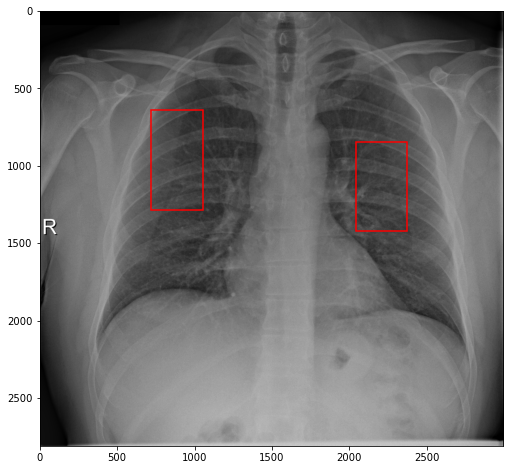

In [65]:
box = image_df.loc[image_df['id']=='65761e66de9f_image'].reset_index(drop=True)
from ast import literal_eval

import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, cmap="gray")
# Create a Rectangle patch
rect1 = patches.Rectangle((720.65215, 636.51048), 332.19348, 648.12561, linewidth=1.5, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((2044.77989, 847.90622), 329.87049, 576.11169, linewidth=1.5, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

Ahora que tenemos una idea de cómo es una radiografía, procederemos a comparlas entre las etiquetas de diagnóstico

In [71]:
def get_samples(num):
    study_df_grp = pd.melt(study_df, id_vars=list(study_df.columns)[:1], value_vars=list(study_df.columns)[1:],
             var_name='label', value_name='value')
    study_df_grp = study_df_grp.loc[study_df_grp['value']!=0].reset_index(drop=True)
    labels = list(study_df_grp['label'].unique())
    study_samples = {}
    for label in labels:
        study_ids = study_df_grp.loc[study_df_grp['label'] == label].sample(num)['id'].tolist() #Get num sample rows from the datafame
        samples = []
        for study_id in study_ids:
            image = {}
            study_instance_id = study_id.split('_')[0]
            image_id = image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['id'].values[0].split('_')[0] #Get the image matching study id
            file_name = [string for string in all_files if image_id in string]
            image['study_id'] = study_instance_id
            image['dicom_file'] = file_name[0]
            #Get the bounding boxes
            box = None
            try:
                box = literal_eval(image_df.loc[image_df['StudyInstanceUID']==study_instance_id]['boxes'].values[0])
            except ValueError:
                pass
            image['boxes'] = box
            samples.append(image)
        study_samples[label] = samples
    return study_samples

samples = get_samples(6)

def display_all_class_samples():
    ''' Input : List of samples 
    '''
    all_class_samples = []
    for key in samples:
        sample_dict = samples[key][0]
        sample_dict['class'] = key
        all_class_samples.append(sample_dict)
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(all_class_samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if 'boxes' in item and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('{}'.format(item['class']),fontsize = 18)    
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Samples across all classes',fontsize = 20)
    plt.show()


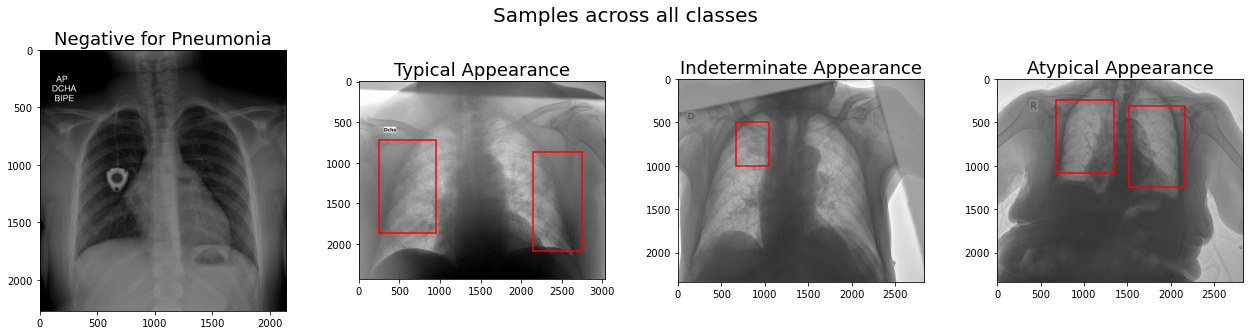

In [72]:
display_all_class_samples()

Es útil poder ver las radiografías entre las diferentes clases ahora procederemos a explorar cada categoría:

In [77]:
def display_samples(samples, title, draw_boxes=False):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if draw_boxes == True and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle(title,fontsize = 20)
    plt.show()

    

def display_histogram(samples, title):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        sub_plot = sns.histplot(img.flatten(), ax=ax)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Image Histogram - {}'.format(title),fontsize = 20)
    plt.show()

**Negativo neumonía**

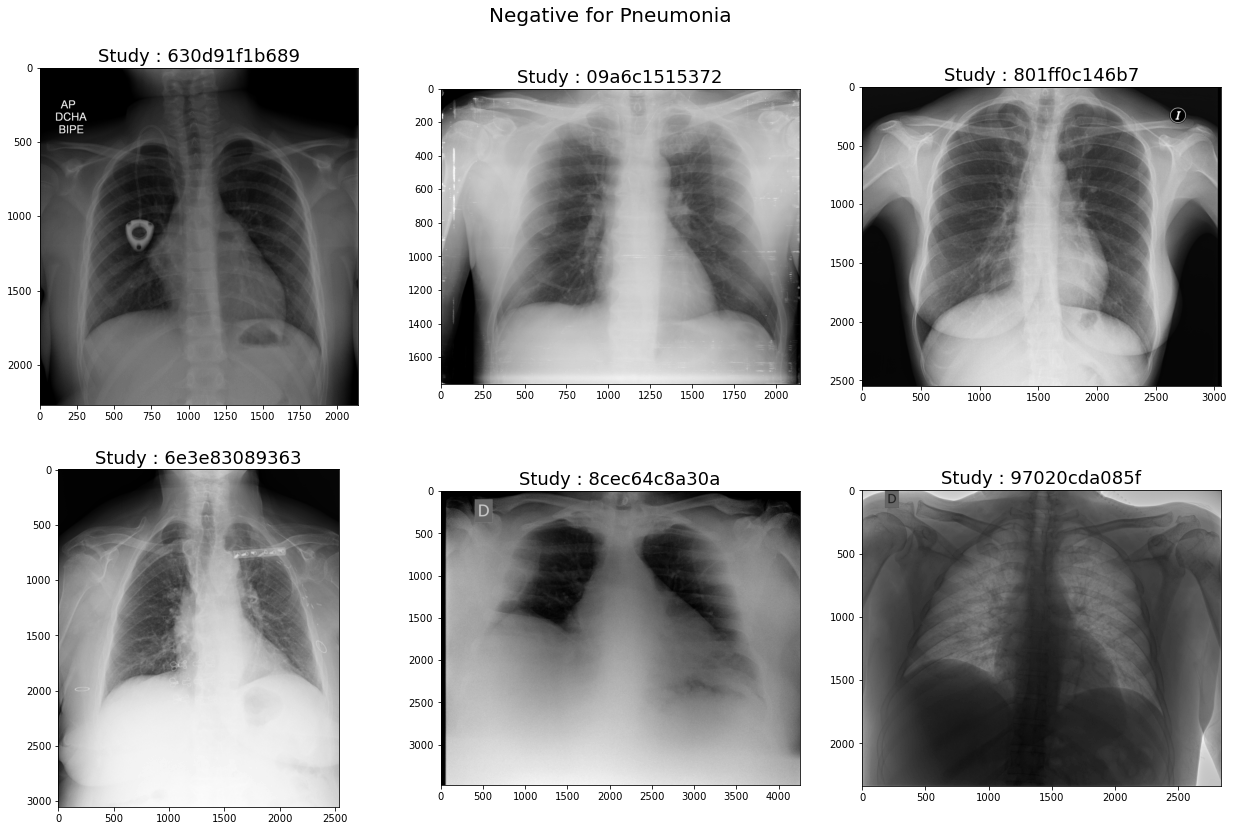

In [75]:
display_samples(samples['Negative for Pneumonia'],'Negative for Pneumonia', draw_boxes=True)

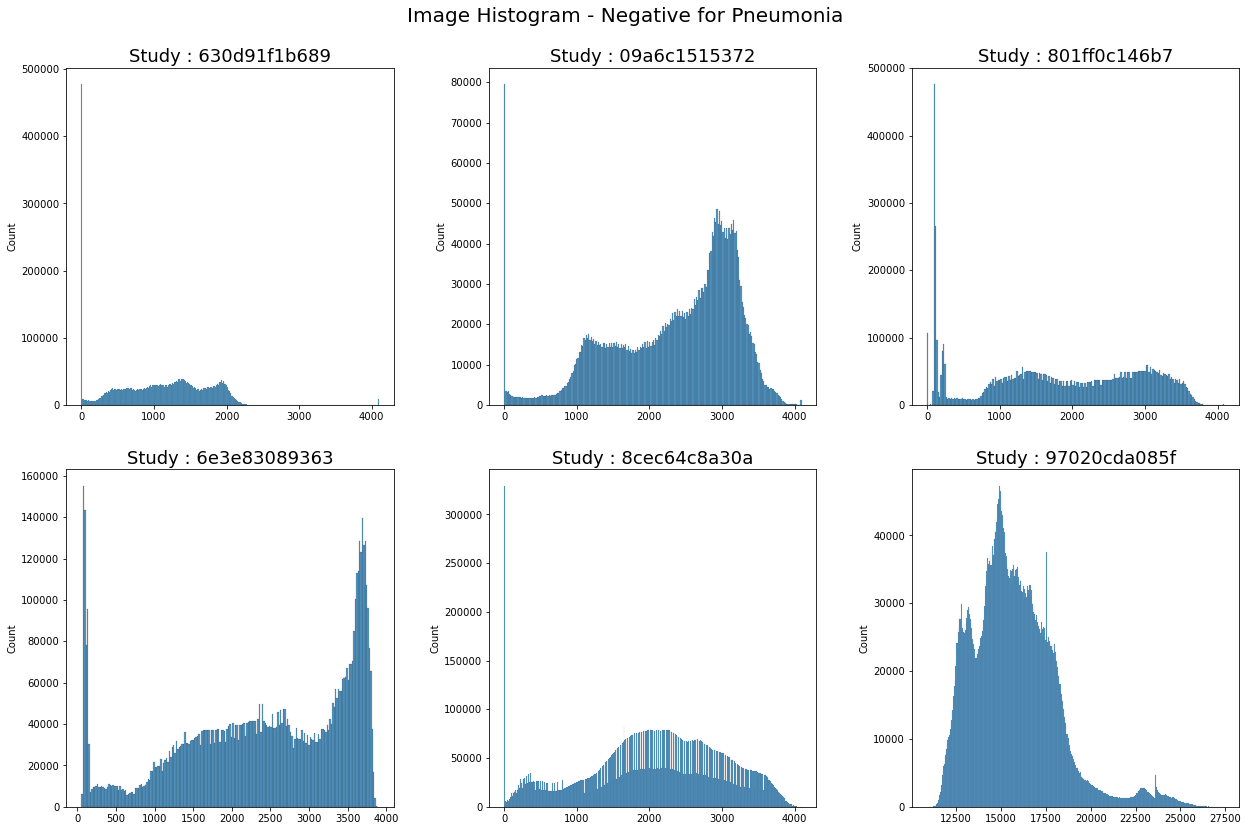

In [78]:
display_histogram(samples['Negative for Pneumonia'],'Negative for Pneumonia')

**Aspecto típico**

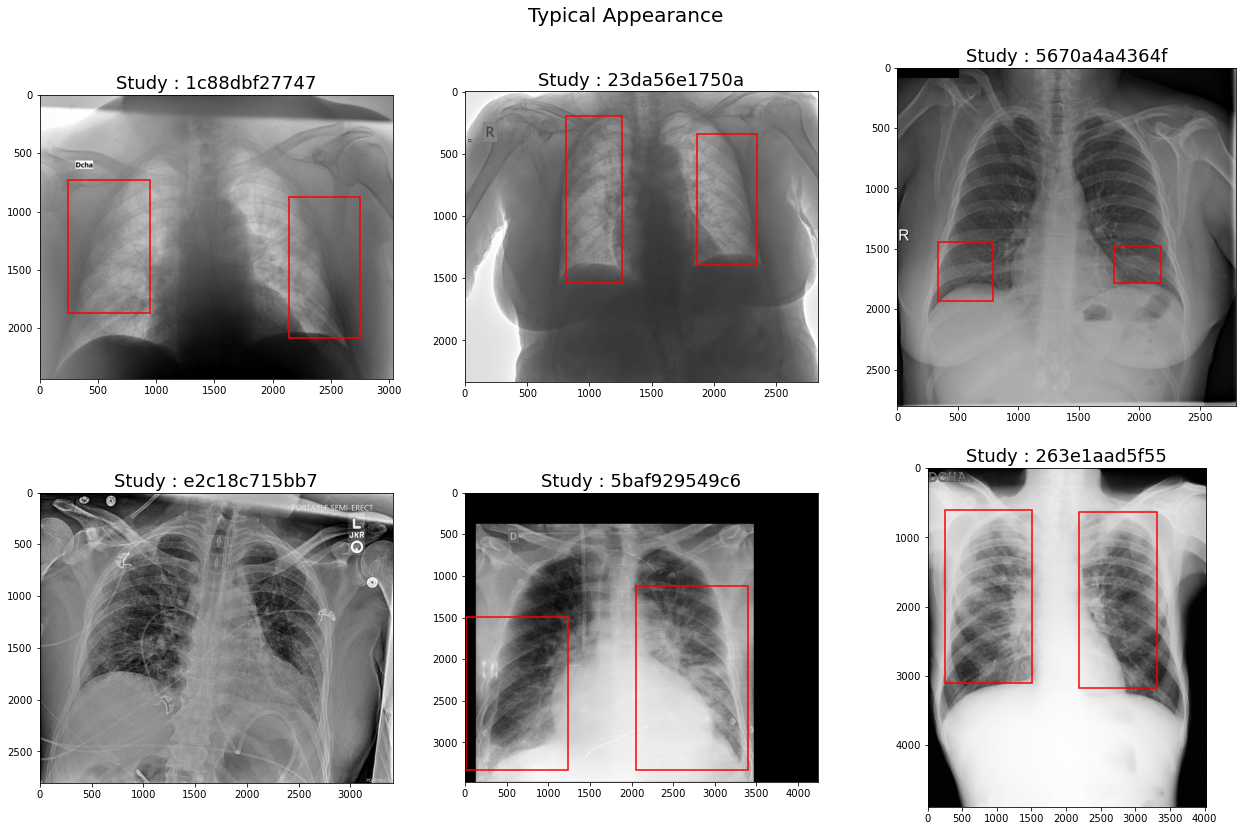

In [85]:
display_samples(samples['Typical Appearance'],'Typical Appearance', draw_boxes=True)

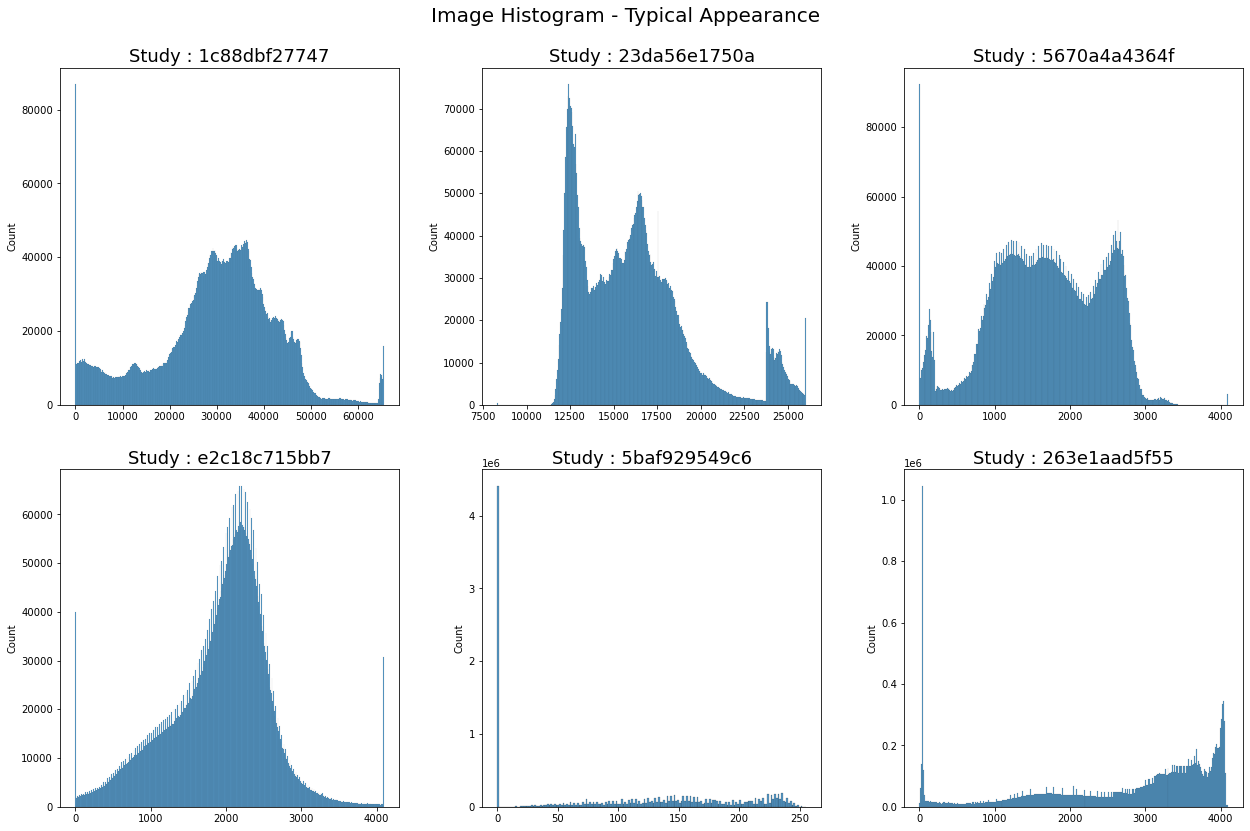

In [86]:
display_histogram(samples['Typical Appearance'],'Typical Appearance')

**Apariencia intermedia**

In [ ]:
display_samples(samples['Indeterminate Appearance'],'Indeterminate Appearance', draw_boxes=True)

In [ ]:
display_histogram(samples['Indeterminate Appearance'],'Indeterminate Appearance')

**Apariencia atípica**

In [ ]:
display_samples(samples['Atypical Appearance'],'Atypical Appearance', draw_boxes=True)

In [ ]:
display_histogram(samples['Atypical Appearance'],'Atypical Appearance')

Con esto tenemos una idea de cómo son las imágenes DICOM pero aún no las hemos explotado al 100% pues ellas manejan un espacio para metadata, procederemos a explorar este espacio:


In [90]:
def get_files(file_format):
    files=[]
    train_files = []
    for file in all_files:
        if file_format in file:
            files.append(file)
    return files
train_files = get_files('/train/')

In [91]:
train_df = extract_metadata(columns, train_files)

NameError: name 'extract_metadata' is not defined

In [ ]:


train_df['Rows'] = train_df['Rows'].astype(int)
train_df['Columns'] = train_df['Columns'].astype(int)
train_df.to_csv('train_imgs_meta.csv', index=None)



Metadata de las imágenes de entrenamiento

In [ ]:
train_df

Exploraremos aún más esta data :

In [ ]:
train_df['PatientSex'].value_counts().reset_index()\
    .style.background_gradient(subset=['PatientSex'], cmap='winter_r')\

In [ ]:
train_df['BodyPartExamined'].value_counts().reset_index()\
    .style.background_gradient(subset=['BodyPartExamined'], cmap='nipy_spectral_r')\

In [ ]:
train_df['BitsStored'] = train_df['BitsStored'].astype(int)
def combine_image_size(row):
    return str(row['Rows']) + ',' + str(row['Columns'])
train_df['ImageSize'] = train_df.apply(lambda x: combine_image_size(x), axis=1)

In [ ]:
fig = go.Figure(go.Scattergl(
    x=train_df['Rows'], y=train_df['Columns'],
    name='Image Size',
    mode='markers',  
    marker=dict(
        color='#0092CC',
    )
))
fig.update_layout(xaxis={'title' : 'Rows', 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Columns'},
                      showlegend=False,
                     title = 'Train - image size')
fig.update_traces(textfont_size=16)
fig.show()